Pedro Daia Cardoso - Image Regression 

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.all import *

Image Regression - treinar um dataset em que a independent var é imagem, e a dependent var é um ou mais floats.

Objetivo: fazer um key point model -> identificar um ponto específico em uma imagem, neste caso, vamos procurar o centro de rostos de pessoas.

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path

path.ls()

(#50) [Path('16.obj'),Path('20'),Path('08'),Path('06.obj'),Path('17'),Path('23'),Path('14.obj'),Path('18'),Path('13.obj'),Path('19.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

`"path/##/frame_####_(pose | rgb).(txt | jpg)"`

In [7]:
img_files = get_image_files(path)
img_files

(#15678) [Path('20/frame_00187_rgb.jpg'),Path('20/frame_00468_rgb.jpg'),Path('20/frame_00380_rgb.jpg'),Path('20/frame_00096_rgb.jpg'),Path('20/frame_00335_rgb.jpg'),Path('20/frame_00079_rgb.jpg'),Path('20/frame_00552_rgb.jpg'),Path('20/frame_00425_rgb.jpg'),Path('20/frame_00112_rgb.jpg'),Path('20/frame_00050_rgb.jpg')...]

In [19]:
im = PILImage.create(img_files[1])
im.shape

(480, 640)

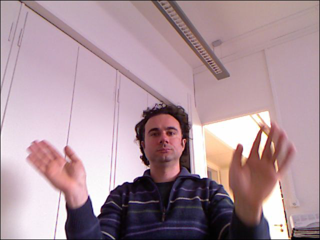

In [20]:
im.to_thumb(320)

Agora, o próprio site do dataset explica o formato da pose.txt files associada a cada imagem, que contem a localização do centro da cabeça em cada img. Como os detalhes deste cálculo não são importantes, aqui é a função desenvolvida por eles para achar o centro a partir do pose.txt:

In [21]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
def getCenter(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [22]:
getCenter(img_files[1])

tensor([345.6619, 272.8406])

Esse tensor são as coordenadas do centro do rosto na imagem.